## Image caption generator
### Capstone project by Hema Kavuri and Sravya Pamula

We use Pytorch libary to build the image caption generator using the Flickr8k dataset. As this dataset consists of images and just captions file, we do not have any EDA to be done. We look at the structure of the data and directly move to modeling.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" -d "/content/Dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: /content/Dataset/flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/Dataset/flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: /content/Dataset/flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/Dataset/flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: /content/Dataset/flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: /content/Dataset/flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: /content/Dataset/flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: /content/Dataset/flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: /content/Dataset/flickr8k/images/2847514745_9a35493023.jpg  
  inflating: /content/Dataset/flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: /content/Dataset/flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/Dataset/flickr8k/images/2848266893_9693

In [ ]:
df = pd.read_csv("/content/Dataset/flickr8k/captions.txt", sep=",")
pd.set_option('display.max_colwidth', None)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [ ]:
df.shape

(40455, 2)

In [ ]:
!python -m spacy download en

2023-04-26 14:01:38.360583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 14:01:39.721488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-26 14:01:41.077071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-26 14:01:41.077578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
import os  
import pandas as pd 
import spacy  # we use spacy for implementation of tokenizer.
import torch
from torch.nn.utils.rnn import pad_sequence  # padding of batch.
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load imgage
import torchvision.transforms as transforms

In [ ]:
spacy_eng = spacy.load('en_core_web_sm') # to know tokenizer it is working with.

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} # Padd Token , Start of sentence, End of sentence, Unknown.
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self): # getting length of our vocabulory.
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)] # we get lower case of the tokenizer of text we send.
        # example:>  "Get along soon" -> ["get","along","soon"]

    def build_vocabulary(self, sentence_list): # used to go through each of text and see if its over the threshold and if so we ignore it.
        frequencies = {}
        idx = 4  # we are starting with an index of 4 because we already included first three.

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies: 
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1 

                if frequencies[word] == self.freq_threshold: # here we see if frequency of word is equad to the threshold frequency.
                    self.stoi[word] = idx # So we set the index starting at 4.
                    self.itos[idx] = word # and we set word into that index.
                    idx += 1 # we increment the index.

    def numericalize(self, text): # we take the sentence and convert them to numerical values.
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] # if token are in stoi, then it surparses the frequency threshold.
                                             #Else it wouldnt be in self.toi and we just return the index of unkown token.
            for token in tokenized_text
        ]

In [ ]:
class FlickrDataset(Dataset): # Talking the class dataset.
    
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5): # root directory of image is passed with caption file and a fequency threshold.
        self.root_dir = root_dir # getting the root directory, in our case, we have flickr8k folder.
        self.df = pd.read_csv(captions_file) # reading the captions from caption file.
        self.transform = transform # 

        
        self.imgs = self.df["image"]  # we get the image from image column.
        self.captions = self.df["caption"] # we get the caption assosiated with image from image column.

        
        self.vocab = Vocabulary(freq_threshold) # Initialize vocabulary with respect to threshold we specified.
        self.vocab.build_vocabulary(self.captions.tolist()) # We build the vocabulory here and the captions is passed as a list into the function's parameters.

    def __len__(self): # we get length of dataframe here.
        return len(self.df)

    def __getitem__(self, index): # we use to get a single example with corresponding caption.
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB") # loading of image.

        if self.transform is not None: # in case we have a stransform we can use it.
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]] # string to index -> index of start token.
        numericalized_caption += self.vocab.numericalize(caption) # we numericalize the caption.
        numericalized_caption.append(self.vocab.stoi["<EOS>"]) # append end of sentence.

        return img, torch.tensor(numericalized_caption) #return image by converting numnericalized caption to tensor.

In [ ]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx # getting the padd index.

    def __call__(self, batch): # we have batch, which is list of all examples we have.
        # unsqueze -> Returns a new tensor with a dimension of size one inserted at the specified position.
        imgs = [item[0].unsqueeze(0) for item in batch] # 1st item returned for each item in batch.
        # torch.cat -> Concatenates the given sequence of seq tensors in the given dimension. 
        imgs = torch.cat(imgs, dim=0) #Concates the images we unsquezed to given dimension. All images must be of same size.
        targets = [item[1] for item in batch] # targets are the captions.
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx) # targets are papdded with pad_sequence function.
        # if batch_first = True,  If True, then the input and output tensors are provided as (batch, seq, feature).

        return imgs, targets # images and targets are returned.

In [ ]:
def get_loader(  # loads everything for us.
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset
    transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor(),]
    )

    loader, dataset = get_loader(
        "/content/drive/MyDrive/DataSet/images", "/content/drive/MyDrive/DataSet/captions.txt", transform=transform
    )

    for idx, (imgs, captions) in enumerate(loader):
        print("index number: ",idx)
        print("Shape of image is: ",imgs.shape)
        print("numericalized captions: ",captions)
        print("Shape of captions: ",captions.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import statistics
import torchvision.models as models ## used to load the pytorch models for vision


class EncoderCNN(nn.Module): ## encoder class used for the CNN part
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN  ## we use just a pre-trained model.
        self.inception = models.inception_v3(pretrained=True) ## we use the inception model.
        #self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size) ## fully connected, access last linear layer and replace it with linear and map it to embed size.
        #self.relu = nn.ReLU()
        #self.times = []
        #self.dropout = nn.Dropout(0.5, inplace = True)
        #self.inception = nn.Sequential(*list(self.inception.children())[:-1])  
        #num_classes = 10  # Example: 10 classes for classification
        #self.classifier = nn.Linear(2048, embed_size)  
        #self.dropout = nn.Dropout(0.5)

        self.inception.aux_logits = False
        self.inception.fc = nn.Linear(2048, embed_size)
        #self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(0.5)
        
    def forward(self, images): ## take input image and compute features with inception of images.
        features = self.inception(images)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size) # we need embedding here to map our word to get better representation of word.
                                                          # It will take an index and map into some embed size.
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers) ## LSTM model is build here.
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions): ## features and target caption in dataset.
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0) # concatinate the features with the embedding and on dimension 0..
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module): # cnn to rnn is hooked here.
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length): ## upto the max_length words prediction, 50 here.
                hiddens, states = self.decoderRNN.lstm(x, states)  ## at beginning it will be initialized as 0.
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1) # so we taking word with higgest probablity.
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0) # taking the predicted word.

                if vocabulary.itos[predicted.item()] == "<EOS>": # check if vocab is equal to end of sentence then break.
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [ ]:
import torch
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter



def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step


def train():
    global dataset
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="/content/Dataset/flickr8k/images",
        annotation_file="/content/Dataset/flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    if torch.cuda.is_available():
        print('GPU found')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 10

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()
    
    

    for epoch in range(num_epochs):
        print("\n")
        print("\n")
        # Uncomment the line below to see a couple of test cases
        print("Epoch number: ",epoch)

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
            
    torch.save(model, '/content/drive/MyDrive/image-captioning-model.pth')



In [ ]:
if __name__ == "__main__":
    train()
print("Running is done")

GPU found


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 189MB/s] 






Epoch number:  0
=> Saving checkpoint






Epoch number:  1
=> Saving checkpoint






Epoch number:  2
=> Saving checkpoint






Epoch number:  3
=> Saving checkpoint






Epoch number:  4
=> Saving checkpoint






Epoch number:  5
=> Saving checkpoint






Epoch number:  6
=> Saving checkpoint






Epoch number:  7
=> Saving checkpoint






Epoch number:  8
=> Saving checkpoint






Epoch number:  9
=> Saving checkpoint


Running is done


In [ ]:
model = torch.load('/content/drive/MyDrive/image-captioning-model.pth', map_location=torch.device('cpu'))
model.eval()

CNNtoRNN(
  (encoderCNN): EncoderCNN(
    (inception): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=T

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
train_loader, dataset = get_loader(
        root_folder="/content/Dataset/flickr8k/images",
        annotation_file="/content/Dataset/flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

In [ ]:
def caption_all_images(image_paths):
    count = 0
    for img_path in image_paths:
        count = count + 1
        print("Image ", count)
        plt.figure(figsize=(6,4))
        full_path = '/content/drive/MyDrive/test_examples/' + img_path
        img = transform(Image.open(full_path).convert("RGB")).unsqueeze(0)
        caption = ' '.join(model.caption_image(img.to('cuda'), dataset.vocab)[1:-1])
        read_img = plt.imread(full_path)
        plt.imshow(np.real(read_img))
        plt.axis("on")
        plt.title(caption)
        plt.show()
        print("\n")

Image  1


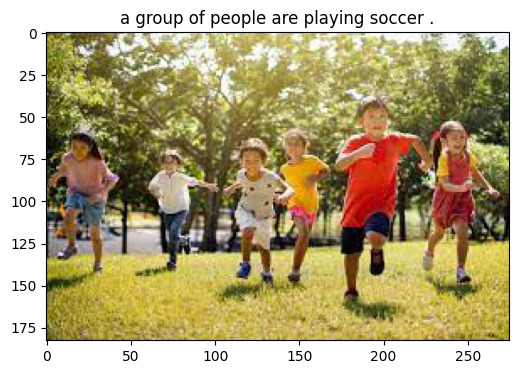



Image  2


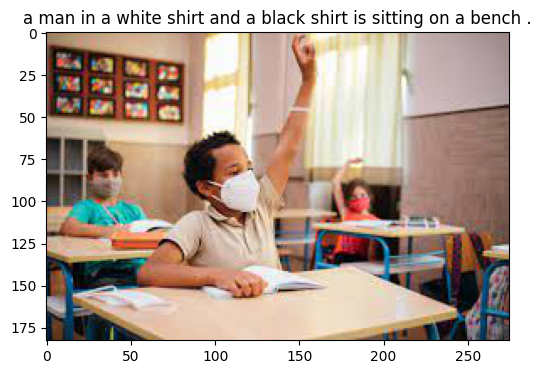



Image  3


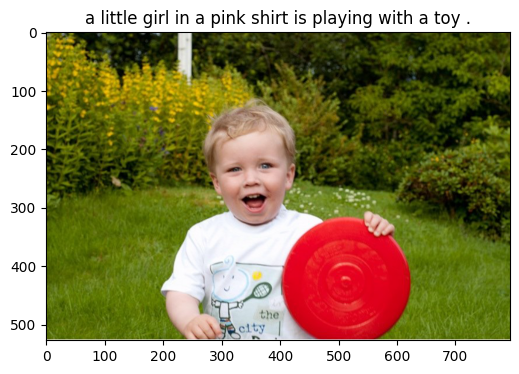



Image  4


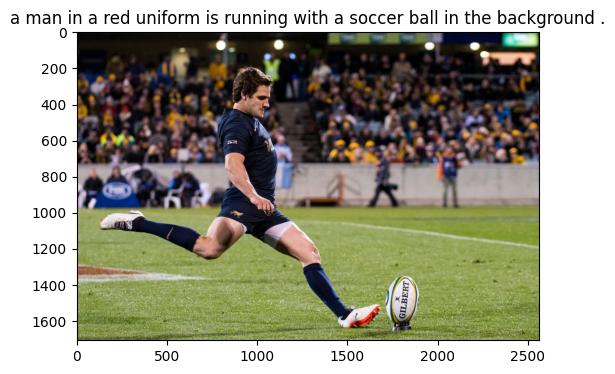



Image  5


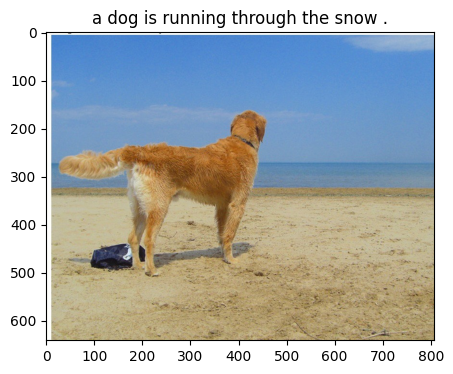



Image  6


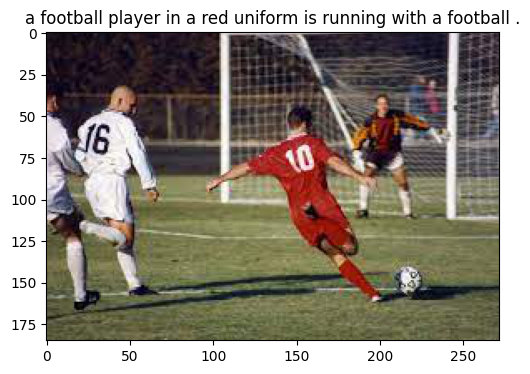



Image  7


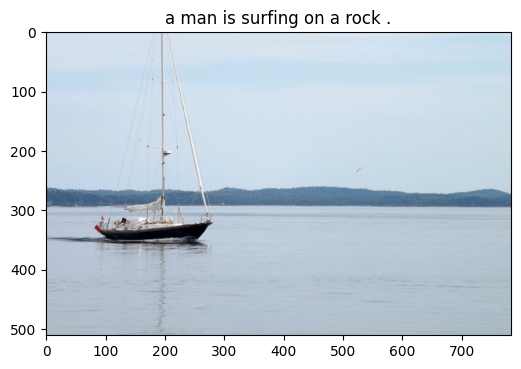



Image  8


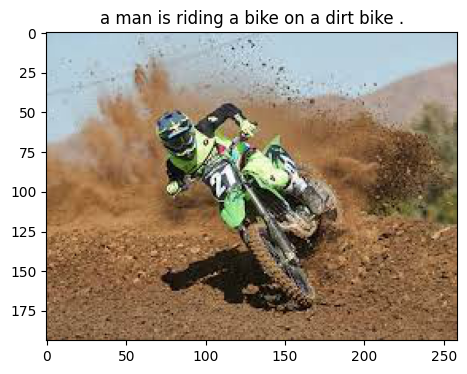

In [ ]:
caption_all_images(os.listdir('/content/drive/MyDrive/test_examples'))

In [ ]:
def caption_custom_image(img_path):
    #count = 0
    #for img_path in image_paths:
    #count = count + 1
    #print("Image ")
    plt.figure(figsize=(6,4))
    full_path = '/content/' + img_path
    img = transform(Image.open(full_path).convert("RGB")).unsqueeze(0)
    caption = ' '.join(model.caption_image(img.to('cuda'), dataset.vocab)[1:-1])
    read_img = plt.imread(full_path)
    plt.imshow(np.real(read_img))
    plt.axis("on")
    plt.title(caption)
    plt.show()
    print("\n")

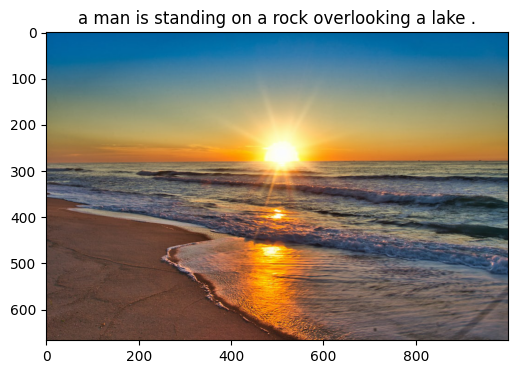

In [ ]:
caption_custom_image('sunrise.jpg')

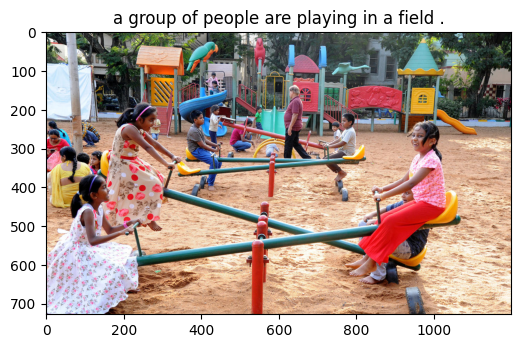

In [ ]:
caption_custom_image('park.jpg')

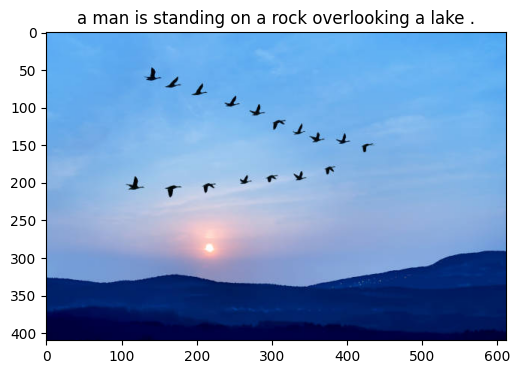

In [ ]:
caption_custom_image('test.jpg')